# 학습 내용
 - 2.1 Pytorch MNIST - CNN(Dropout, Batch Normalization, Check Point Save, Early Stopping)
 - 2.2 Pytorch MNIST - 나만의 모델 만들기 by CNN

# 2.1 Pytorch MNIST - CNN
# Dropout, Batch Normalization, Check Point Save, Early Stopping
- 이번 실습에서는 CNN(Convolutional Nueral Network)을 사용하여 MNIST 데이터셋을 분류하도록 학습시킨다
- Data Augmentation을 통하여 데이터를 증강하여 모델의 분류 성능을 향상시킨다
- Overfitting을 방지하는 Dropout 기법을 사용하여 모델의 학습성능을 개선한다
- Batch Normalization에 대하여 학습한다
- 중간 저장 기법을 사용하여 학습 성능이 가장 좋은 모델이 자동 저장되는것을 확인해본다
- Early Stopping 기법을 사용하여 Over Fitting을 방지한다

## 2.1.1 PyTorch GPU 구동 가능 여부 확인하기
- 필요한 라이브러리를 불러온다
- Pytorch를 GPU로 구동할수 있는 조건인지를 확인한다
- 결과가 CPU로 나오면, 가상환경을 지우고 다시 깔아야 한다 (Pytorch, Keras 가상환경 만드는법.pptx 참조)

In [1]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

GPU 사용 불가능 상태


- 교육 환경에서의 seed 고정(random성을 고정시킴)

In [2]:
def seed(seed = 1234):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed() # 시드 고정

## 2.1.2 하이퍼 파라미터 설정
- 모델 구동에 필요한 하이퍼 파라미터들을 설정한다.
- 하이퍼 파라미터 설정값에 따라서 모델의 구동 속도, 정확도, 학습 속도가 달라진다.

In [3]:
# Data Load
batch_size = 128

# Learning
maximum_epoch = 10
learning_rate = 0.01

## 2.1.3 데이터 로드 & 전처리
- MNIST 데이터를 다운로드 받는다.
- Train, Validation, test 데이터를 분할해준다.

In [4]:
# Image Net 추천 평균 & 표준편차
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize

mnist_transform = transforms.Compose([ToTensor(),
                                      Normalize(mean=(0.5,), std=(0.5, ))
])

from torchvision import datasets
train_data = datasets.MNIST(root = './', train = True, download = True, transform = mnist_transform)

from torch.utils.data import random_split
train_data, valid_data = random_split(train_data, [54000, 6000])
test_data = datasets.MNIST(root = './', train = False, download = True, transform = mnist_transform)

In [5]:
print('Train 길이: {}'.format(len(train_data)))
print('Valid 길이: {}'.format(len(valid_data)))
print('Test  길이: {}'.format(len(test_data)))

Train 길이: 54000
Valid 길이: 6000
Test  길이: 10000


- Train / Validation / Test 데이터가 제대로 나뉘었는지 길이를 확인
- 데이터를 시각화하여 확인한다
- 숫자 0 ~ 9로 구성된 MNIST 데이터는 28 * 28 픽셀로 이루어졌다
- 각 데이터마다 라벨이 존재한다 (예: 아래의 1로 보이는 숫자 그림은 라벨이 1로 되어있다)

Content of Y (Label, type = <class 'int'>) = 0
Shape of X(Data, type = <class 'torch.Tensor'> = torch.Size([1, 28, 28]))


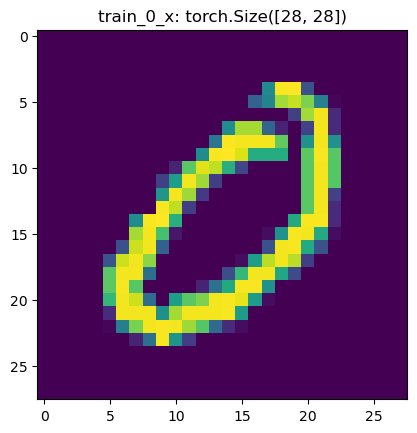

In [6]:
seed() # 시드 고정
train_0_x, train_0_y = train_data[1] # x가 사진, y는 라벨 데이터
print('Content of Y (Label, type = {}) = {}'.format(type(train_0_y), train_0_y))
print('Shape of X(Data, type = {} = {})'.format(type(train_0_x), train_0_x.shape))

import matplotlib.pyplot as plt
plt.figure(1)
plt.imshow(train_0_x.squeeze())
plt.title('train_0_x: {}'.format(train_0_x.squeeze().shape))
plt.show()

In [7]:
seed() # 시드 고정
# Train / Validation / Test 셋에 대한 데이터 로더 만들기
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), pin_memory=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

# Train 부분의 데이터 로더를 확인 해보기
train_enumerator = enumerate(train_loader) # train_loader의 값과 순서를 추출

In [8]:
seed() # 시드 고정
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)

print('순서: / X모양: {} / Y모양: {}'.format(ex_batch_idx, ex_data.shape, ex_label.shape))
print('Y 0 ~ {} 출력: {}'.format(batch_size, ex_label))

순서: / X모양: 0 / Y모양: torch.Size([128, 1, 28, 28])
Y 0 ~ 128 출력: tensor([5, 9, 7, 4, 5, 5, 7, 0, 6, 0, 7, 9, 3, 0, 8, 2, 5, 5, 0, 9, 3, 9, 7, 9,
        2, 1, 1, 8, 3, 3, 6, 5, 8, 6, 0, 9, 4, 8, 4, 6, 5, 3, 6, 2, 0, 7, 0, 7,
        7, 6, 9, 7, 8, 9, 5, 4, 0, 3, 0, 0, 6, 1, 1, 7, 4, 1, 9, 9, 0, 8, 6, 8,
        0, 1, 5, 9, 0, 9, 9, 7, 2, 0, 7, 2, 2, 5, 8, 9, 2, 7, 4, 3, 9, 5, 5, 3,
        1, 2, 1, 4, 1, 5, 6, 1, 9, 8, 8, 7, 1, 1, 4, 2, 8, 7, 9, 5, 1, 8, 7, 7,
        0, 0, 7, 3, 2, 7, 0, 2])


## 2.1.4 모델 선언 - CNN
### Batch Normalization (X)
### Drop Out (X)
### Best Model Save (X)

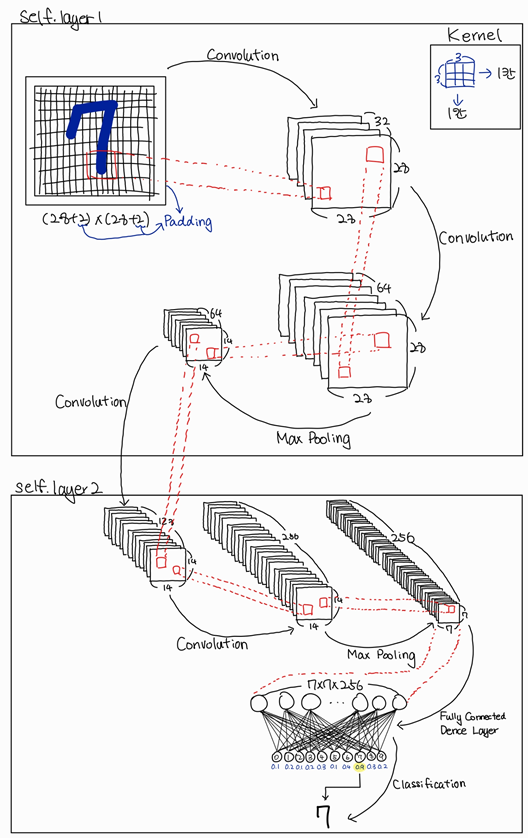

### 모델 선언

In [9]:
import torch.nn as nn
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        
        # 코딩타임 - 3분
        
        # 1번 레이어 생성
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # padding으로 인해 사이즈 보존
            nn.ReLU(), # ReLU함수에 통과시킨다.
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # padding으로 인해 사이즈 보존
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # 커널 사이즈 2, stride 2로 통과시킴으로서 사진 크기가 1/2로 줄어듬
        
        # 2번 레이어 생성
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        #마지막 0 ~ 9 classification을 위한 fully connected layer 생성
        self.fc1 = nn.Linear(7 * 7 * 256, 10) # 2번의 맥스풀링을 거쳐서 28 -> 14 -> 7이 되었고 채널이 256개
        nn.init.xavier_uniform_(self.fc1.weight) # 가중치 초기화
        
        ##########


   #모델 설계 후 데이터셋이 layer들을 통과할 수 있게 함.
    def forward(self, x):
           
        conv_out = self.layer1(x)
        out = self.layer2(conv_out)
        out = out.view(out.size(0), -1) # 3차원 -> 1차원 Flatten
        out = self.fc1(out)

        return out, conv_out

# Model structure check
from torchsummary import summary as Summary
Summary(CNN_model().to(device),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6          [-1, 128, 14, 14]          73,856
              ReLU-7          [-1, 128, 14, 14]               0
            Conv2d-8          [-1, 256, 14, 14]         295,168
              ReLU-9          [-1, 256, 14, 14]               0
        MaxPool2d-10            [-1, 256, 7, 7]               0
           Linear-11                   [-1, 10]         125,450
Total params: 513,290
Trainable params: 513,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## 학습에 사용되는 함수
 - 초기화
 - 모델 구동
 - 학습 추이

### 초기화

In [10]:
# 모델 초기화
from torch.optim import Adam
def init_model():
    plt.rc('font', size = 10)
    global net, loss_fn, optim
    net = CNN_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
    
# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0
    
def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

### 모델 구동

In [11]:
import gc
from torch.cuda import memory_allocated, empty_cache
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()
    
# 학습 알고리즘
import numpy as np
def epoch(data_loader, mode = 'train'):
    global epoch_cnt
    
    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed, last_out, last_label = [], [], False, None, None
    
    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)
        
        
        # 코딩타임 - 1분
        
        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            net.eval()
            
        ##########

        result, _ = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출
        
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
        
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기르 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
            
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록
            
        # 5. 컨퓨전 매트릭스 출력을 위해 기록
        last_out = out.cpu().detach() # 모든 Predict 기록
        last_label = _label # 모든 GT 기록
        
    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1
    
    clear_memory()
    
    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc), last_out, last_label

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

### 학습 추이

In [12]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
    
def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # 학습 추이 출력
    
    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)
    
    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5} | V_Loss {:5} | V_acc. {:5} | \
🕒 {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)
    
    log_stack.append(log_str) # 프린트 준비
    
    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

### 모델 학습

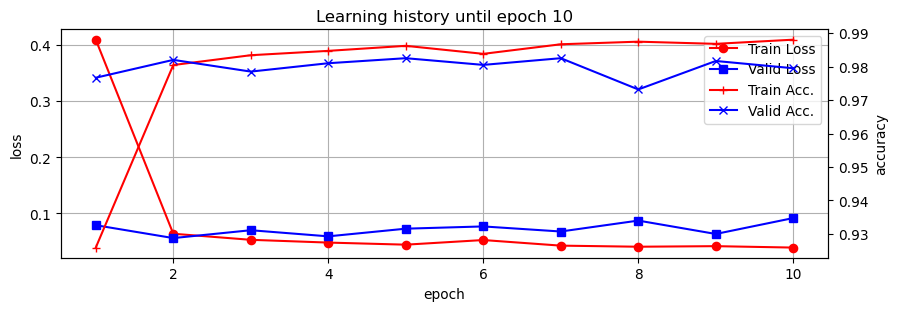

Epoch:  10 | T_Loss 0.039 | T_acc 0.988 | V_Loss 0.092 | V_acc. 0.979 | 🕒 120.877
Epoch:   9 | T_Loss 0.042 | T_acc 0.987 | V_Loss 0.063 | V_acc. 0.982 | 🕒 120.536
Epoch:   8 | T_Loss 0.041 | T_acc 0.987 | V_Loss 0.087 | V_acc. 0.973 | 🕒 121.613
Epoch:   7 | T_Loss 0.043 | T_acc 0.987 | V_Loss 0.068 | V_acc. 0.983 | 🕒 120.667
Epoch:   6 | T_Loss 0.053 | T_acc 0.984 | V_Loss 0.077 | V_acc.  0.98 | 🕒 406.43
Epoch:   5 | T_Loss 0.044 | T_acc 0.986 | V_Loss 0.073 | V_acc. 0.983 | 🕒 120.738
Epoch:   4 | T_Loss 0.048 | T_acc 0.985 | V_Loss 0.059 | V_acc. 0.981 | 🕒 121.101
Epoch:   3 | T_Loss 0.053 | T_acc 0.983 | V_Loss  0.07 | V_acc. 0.979 | 🕒 122.241
Epoch:   2 | T_Loss 0.064 | T_acc  0.98 | V_Loss 0.056 | V_acc. 0.982 | 🕒 119.8
Epoch:   1 | T_Loss 0.409 | T_acc 0.926 | V_Loss 0.079 | V_acc. 0.977 | 🕒 116.343

 Training completed!


In [13]:
seed() # 시드 고정
# Training Initialization
init_model()
init_epoch()
init_log()

# Training Iteration
import time
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad(): # 역전파 학습을 하지 말도록(더 이상 경사로(gradient)를 트래킹하지 않는다)
        vloss, vacc, _, _ = epoch(valid_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

### 결과 분석

In [ ]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, _, _ = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

 - CNN 기본
 - CNN(Dropout, Batch Normalization, Best Model Save) 적용 후  <---
 - CNN 결과 분석(Confustion Matrix)
 - CNN 결과 분석(틀린 결과 보기)
 - Early Stopping
 - 자신의 모델 만들기

# 2.1.5 모델 선언후 학습 - CNN
### Batch Normalization (O)
### Drop Out (O)
### Best Model Save (O)

### 모델 선언

In [ ]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        
        # 1번 레이어 생성
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # padding으로 인해 사이즈 보존
            nn.BatchNorm2d(32), #Batch Normalization을 수행
            nn.ReLU(), # ReLU함수에 통과시킨다.
            nn.Dropout(0.3), # Drop Out 수행            
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 커널 사이즈 2, stride 2로 통과시킴으로서 사진 크기가 1/2로 줄어듬
        )
        
        # 2번 레이어 생성
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        #마지막 0 ~ 9 classification을 위한 fully connected layer 생성
        self.fc1 = nn.Linear(7 * 7 * 64, 10, bias = True) # 2번의 맥스풀링을 거쳐서 28 -> 14 -> 7이 되었고 채널이 64개
        
        #가중치 초기화
        nn.init.xavier_uniform_(self.fc1.weight)

   #모델 설계 후 데이터셋이 layer들을 통과할 수 있게 함.
    def forward(self, x):
        conv_out = self.layer1(x)
        out = self.layer2(conv_out)
        out = out.view(out.size(0), -1) # 3차원 -> 1차원 Flatten
        out = self.fc1(out)
        return out, conv_out

# Model structure check
Summary(CNN_model().to(device),(1, 28, 28))

### 모델 학습

In [ ]:
seed() # 시드 고정
# Training Initialization
init_model()
init_epoch()
init_log()

best_test_acc, best_epoch = 0, 0
# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    
    with torch.no_grad():
        net.eval()
        _, test_acc, _, _ = epoch(test_loader, mode = 'test')
        
        # Test 점수가 가장 좋았던 모델을 저장한다
        if best_test_acc < test_acc:
            best_test_acc = test_acc
            best_epoch = epoch_cnt
            print('Epoch: {} / Test Acc: {} | 최고 점수가 갱신되었습니다. 모델 중간 저장을 시행합니다.\
            '.format(best_epoch, round(best_test_acc, 5)))
            torch.save(net.state_dict(), './model.pth')

print('\n Training completed!')


# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, _, _ = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))
    
print('저장된 Best Model: Epoch: {}/ Test Accuracy: {}'.format(best_epoch, round(best_test_acc, 3)))

### 중간 저장 기법으로 저장된 모델을 불러와서 Test Acc.를 측정

In [ ]:
net = CNN_model().to(device)
net.load_state_dict(torch.load('./model.pth'))

# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, test_out, test_label = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

 - CNN 기본
 - CNN(Dropout, Batch Normalization, Best Model Save) 적용 후
 - CNN 결과 분석(Confustion Matrix)   <---
 - CNN 결과 분석(틀린 결과 보기)
 - Early Stopping
 - 자신의 모델 만들기

### Confustion Matrix를 통한 결과 가시화

In [ ]:
import seaborn as sns # 시각화 라이브러리
from sklearn.metrics import confusion_matrix


# 코딩 타임 - 3분



##########

- 모델이 오 분류하는 케이스에 대해서 분석해보자

 
- 그리고 정답률이 가장 높은 숫자는 1이다. 1이 가장 쉽게 생긴 숫자라서 일까?

 
- 이와 같이 모델이 특정 숫자에서 왜 오 분류율이 높은지를 생각해보고, 어떤 특성을 가졌을 때 분류하기에 유리하고 불리한지를 생각해보자. 또한 이 문제를 어떻게 해결해 볼 수 있을까 고민하는 시간을 가져보자

 - CNN 기본
 - CNN(Dropout, Batch Normalization, Best Model Save) 적용 후
 - CNN 결과 분석(Confustion Matrix)
 - CNN 결과 분석(틀린 결과 보기)   <---
 - Early Stopping
 - 자신의 모델 만들기

# 2.1.6 틀린 결과 분석
 - 모델이 MNIST에서 잘못 분류한 경우를 샘플링한다
 - 샘플링 결과를 보고 이유를 분석해본다
 - 분석한 이유를 토대로 모델의 개선점을 찾는다

In [ ]:
def test(wrong_loader, show_goal_cnt):
    
    # 만약 4로 나누어 떨어지지 않을 경우 카운터 보정
    while True:
        if show_goal_cnt % 4 == 0:
            break
        show_goal_cnt += 1
    
    # 사용되는 변수들 초기화
    plt_pic_list, gt_label_list = [], [] # plt show에 사용할 리스트
    pred_label_list, second_pred_label_list, third_pred_label_list = [], [], [] # plt show에 사용할 리스트(1, 2, 3등 라벨)
    plt_cnt, cnt, show_cnt = 0, 0, 0 # plt show에서 필요한 카운터
    
    for _data, _label in wrong_loader: # 데이터에서 사진과 라벨을 분리
        
        # 코딩타임(데이터를 모델에 넣고 예측 결과 1, 2, 3순위 출력) - 3분
        

            
        ##########
            
            # 정답과 예측 결과가 다른 경우(모델이 잘못 분류한 경우)
            if gt_label != pred_label:
                # plt로 4개를 한번에 출력하기 때문에 4번동안 리스트에 누적시킨다
                show_cnt += 1
                wrong_pic, _ = test_data[cnt]
                plt_pic_list.append(wrong_pic)
                gt_label_list.append(gt_label)
                pred_label_list.append(pred_label)
                second_pred_label_list.append(second_label)
                third_pred_label_list.append(third_label)
                plt_cnt += 1
                
                # 4번 누적이 완료되면, 누적된 값들을 plt로 사진과 함께 출력한다
                if plt_cnt == 4: # 만약 카운터가 4가 되면
                    plt.figure(figsize = (40, 10)) # plt의 가로 세로 사이즈를 정하고
                    plt.rc('font', size = 23) # 폰트 크기를 정한다
                    plt.subplot(141) # 1: 행, 4: 열, 1: 1번째 칸에 들어갈 정보
                    plt.imshow(plt_pic_list[0].squeeze()) # 사진을 출력
                    plt.title('\n\nGround Truth: {} | Wrong Predict: {}\n2nd Predict: {} | 3rd Predict: {}'.format
                              (gt_label_list[0], pred_label_list[0], 
                               second_pred_label_list[0], third_pred_label_list[0]))
                    
                    plt.subplot(142) # 1: 행, 4: 열, 2: 2번째 칸에 들어갈 정보
                    plt.imshow(plt_pic_list[1].squeeze()) # 사진을 출력
                    plt.title('\n\nGround Truth: {} | Wrong Predict: {}\n2nd Predict: {} | 3rd Predict: {}'.format
                              (gt_label_list[1], pred_label_list[1], 
                               second_pred_label_list[1], third_pred_label_list[1]))
                    
                    plt.subplot(143) # 1: 행, 4: 열, 3: 3번째 칸에 들어갈 정보
                    plt.imshow(plt_pic_list[2].squeeze()) # 사진을 출력
                    plt.title('\n\nGround Truth: {} | Wrong Predict: {}\n2nd Predict: {} | 3rd Predict: {}'.format
                              (gt_label_list[2], pred_label_list[2], 
                               second_pred_label_list[2], third_pred_label_list[2]))
                    
                    plt.subplot(144) # 1: 행, 4: 열, 4: 4번째 칸에 들어갈 정보
                    plt.imshow(plt_pic_list[3].squeeze()) # 사진을 출력
                    plt.title('\n\nGround Truth: {} | Wrong Predict: {}\n2nd Predict: {} | 3rd Predict: {}'.format
                              (gt_label_list[3], pred_label_list[3], 
                               second_pred_label_list[3], third_pred_label_list[3]))
                    plt.show()
                    
                    # 다시 카운터 4를 쌓고 춝력을 반복하기 위하여 필요한 변수들을 모두 초기화 한다
                    plt_cnt, plt_pic_list, gt_label_list = 0, [], []
                    pred_label_list, second_pred_label_list, third_pred_label_list = [], [], []
                
            cnt += 1
            
            # 출력하고 싶은 개수가 충족되면 for문을 중간에 빠져나온다
            if show_cnt == show_goal_cnt:
                break
        
        # 출력하고 싶은 개수가 충족되면 for문을 중간에 빠져나온다
        if show_cnt == show_goal_cnt:
            break

# 코딩타임(test용 데이터 로더를 만들고, 함수를 run)

wrong_loader = DataLoader(test_data, pin_memory=True) # batch size 없이 통채로 데이터 로더에 test데이터 삽입
test(wrong_loader, 12)

##########

- 각 숫자의 Ground Truth와 틀린 경우를 12개만 출력해 보았다
- 틀린경우의 2번째로 예측한 숫자와, 3번째로 예측한 숫자를 같이 볼 수 있다
- 2 ~ 3번째 예측 결과 안에 정답이 있는 경우도 있지만, 없는 경우도 있다
- 이 결과를 바탕으로 현재 모델의 단점과, 개선 방안을 생각해 본다

 - CNN 기본
 - CNN(Dropout, Batch Normalization, Best Model Save) 적용 후
 - CNN 결과 분석(Confustion Matrix)
 - CNN 결과 분석(틀린 결과 보기)
 - Early Stopping   <---
 - 자신의 모델 만들기

# 2.1.7 Early Stopping
 - Train, Validation 데이터로 학습을 과도하게 시키면 Validation 만을 위해 학습이 이루어져서 Over fitting이 일어난다
 - 이를 방지하기 위하여, 학습률이 더 이상 상승하지 않게 되면 학습을 멈출 수 있다
 - 매 epoch마다 줄어드는 validation loss를 모니터링하여 일정 patience 이상 성능 향상이 없으면 학습을 조기 종료한다

### Early Stopping을 위한 가벼운 cnn모델 제작
 - Early Stopping을 본 모델에 제대로 적용하면 모델이 학습을 오래 하기 때문에 시간이 오래 걸린다
 - Early Stopping이 작동하는 모습을 빠르게 확인하기 위하여 학습이 빠른 가벼운 모델을 임시로 만든다(성능 안좋은 모델)

### 하이퍼 파라미터 설정

In [ ]:
# Learning
maximum_epoch = 9999 # Early Stopping이 동작할 것을 감안하여 매우 높게 설정
learning_rate = 0.01 # Early Stopping이 빨리 동작할 수 있도록 Learning Rate를 높게 설정
patience = 10 # n번 연속으로 Validation Loss가 개선이 안되면 학습을 중지한다

### 빠른 Early Stopping 테스트를 위하여 학습 데이터 줄이기

In [ ]:
seed() # 시드 고정
mnist_transform = transforms.Compose([ToTensor(),
                                      Normalize(mean=(0.5,), std=(0.5,))
])

train_data_es = datasets.MNIST(root = './', train = True, download = True, transform = mnist_transform)
train_data_es, valid_data_es, _ = random_split(train_data_es, [500, 200, 59300])
test_data_es = datasets.MNIST(root = './', train = False, download = True, transform = mnist_transform)

In [ ]:
seed() # 시드 고정
# Create data loader
train_loader_es = DataLoader(train_data_es, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
valid_loader_es = DataLoader(valid_data_es, batch_size=batch_size, pin_memory=True)
test_loader_es = DataLoader(test_data_es, batch_size=batch_size, pin_memory=True)

### 빠른 Early Stopping 테스트를 위하여 가벼운 모델 설계

In [ ]:
def init_model():
    global net, loss_fn, optim
    net = CNN_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
    
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.fc1 = nn.Linear(14 * 14 * 8, 10, bias = True)
        nn.init.xavier_uniform_(self.fc1.weight)
    def forward(self, x):
        conv_out = self.layer1(x)
        out = conv_out.view(conv_out.size(0), -1)
        out = self.fc1(out)
        return out, conv_out

Summary(CNN_model().to(device),(1, 28, 28))

### Early Stopping에 필요한 기능 선언

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience = 10, verbose = False, delta = 0, path = 'checkpoint.pth', save = False):
#         patience (int): validation loss가 개선된 후 기다리는 기간
#         verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
#         delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
#         path (str): checkpoint저장 경로

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.save = save

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # validation loss가 감소하면 모델을 저장한다.
        if self.verbose:
            print('Validation loss decresed ({:5} --> {:5}). Saving Model...'.format(self.val_loss_min, val_loss))
        if self.save == True:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### 모델 학습(Early Stopping 적용)
 - Early Stopping이 적용되었기 때문에 설정해 놓은 epoch이 다 돌아가지 않고, 중간에 학습을 마친다
 - 중간에 학습을 마치는 이유는, 모델의 학습에 더 이상 발전이 없기 때문이다(Validation Loss가 줄어들지 않음)
 - 모델의 발전이 없다는것을 판단하는 기준은 patience이다
 - 만약 patience가 10이라면, 10번 연속으로 Validation Loss가 줄어들지 않으면 Over fitting이라고 판단하고 학습을 멈추게 된다

In [ ]:
seed() # 시드 고정
# Training Initialization
init_model()
init_epoch()
init_log()

# Early Stopping 선언
early_stopping = EarlyStopping(10)

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader_es, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader_es, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    
    # 코팅타임(early stopping 기능을 모델에 적용)
    

    
    ##########

print('\n Training completed!')
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, _, _ = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

- 학습 중간에 10번 연속으로 Validation Loss가 줄어들지 않아서 학습을 중지했다
- Early Stopping 기능을 빠르게 보기 위해 만든 모델이므로 정확도는 매우 낮다

# ============================================================

 - CNN 기본
 - CNN(Dropout, Batch Normalization, Best Model Save) 적용 후
 - CNN 결과 분석(Confustion Matrix)
 - CNN 결과 분석(틀린 결과 보기)
 - Early Stopping
 - 자신의 모델 만들기   <---

# 2.2 Pytorch MNIST - 모델의 성능을 직접 높혀보자
 - CNN의 구조를 바꾸어 나만의 모델을 만들어보자
 - 목표 정확도: 99.5점 만들기
 - 바꿀 수 있는 하이퍼 파라미터: Learning Rate, Batch size, Epochs, Optimizer, Activation Function, 모델 레이어 구조 등

### 모델 선언(Batch Normalization, Dropout, Early Stopping, Check Point Save 모두 적용된 모델 예시)

In [ ]:
maximum_epoch = 30
learning_rate = 0.005

def init_model():
    global net, loss_fn, optim
    net = My_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)
    
class My_model(nn.Module):
    def __init__(self):
        super(My_model, self).__init__()
        # 1번 레이어 생성
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1), # padding으로 인해 사이즈 보존
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        
        # 2번 레이어 생성
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        #마지막 0 ~ 9 classification을 위한 fully connected layer 생성
        self.fc1 = nn.Linear(7 * 7 * 64, 10, bias = True) 
        
        #가중치 초기화
        nn.init.xavier_uniform_(self.fc1.weight)

   #모델 설계 후 데이터셋이 layer들을 통과할 수 있게 함.
    def forward(self, x):
        conv_out = self.layer1(x)
        out = self.layer2(conv_out)
        out = out.view(out.size(0), -1) # 설명 1
        out = self.fc1(out)
        return out, conv_out

# Model structure check
Summary(My_model().to(device),(1, 28, 28))

### 모델 학습

In [ ]:
seed() # 시드 고정
# Training Initialization
init_model()
init_epoch()
init_log()
early_stopping = EarlyStopping(patience = 30)

best_test_acc, best_epoch = 0, 0
# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    
    # early_stopping는 validation loss가 감소하였는지 확인
    early_stopping(vloss, net)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    with torch.no_grad():
        net.eval()
        _, test_acc, _, _ = epoch(test_loader, mode = 'test')
        
        # Test 점수가 가장 좋았던 모델을 저장한다
        if best_test_acc < test_acc:
            best_test_acc = test_acc
            best_epoch = epoch_cnt
            print('Epoch: {} / Test Acc: {} | 최고 점수가 갱신되었습니다. 모델 중간 저장을 시행합니다.'.format(best_epoch, round(best_test_acc, 5)))
            torch.save(net.state_dict(), './model.pth')

print('\n Training completed!')

# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, _, _ = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))
    
print('저장된 Best Model: Epoch: {}/ Test Accuracy: {}'.format(best_epoch, round(best_test_acc, 3)))

### 모델의 정확도 출력

In [ ]:
net = My_model().to(device)
net.load_state_dict(torch.load('./model.pth'))

# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, _, _ = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))